In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import yfinance as yf
from tabulate import tabulate

from datetime import datetime as dt
pd.options.display.max_rows = 4000

In [120]:
# We should take bigger timeframe for our model to be accurate
ticker = 'AAPL'
start_date = dt(2010, 1, 1)
end_date = dt.now()
# User can take any stock picker
df = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [121]:
df.shape

(3507, 6)

In [122]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.478997,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.490199,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.386965,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.375156,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.417541,447610800
2010-01-11,7.600000,7.607143,7.444643,7.503929,6.360928,462229600
2010-01-12,7.471071,7.491786,7.372143,7.418571,6.288572,594459600
2010-01-13,7.423929,7.533214,7.289286,7.523214,6.377276,605892000
2010-01-14,7.503929,7.516429,7.465000,7.479643,6.340343,432894000


In [58]:
df.to_csv('output.csv', index=False)

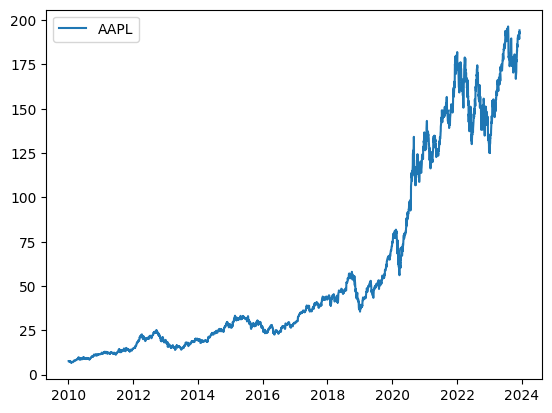

In [59]:
plt.plot(df['Close'],label = 'AAPL')
plt.legend()

In [60]:
# Dropping Date and Adj Close Column
df = df.drop(['Adj Close'], axis = 1)

In [61]:
df = df.reset_index(drop = True)
df.head()

,Open,High,Low,Close,Volume
0,7.622500,7.660714,7.585000,7.643214,493729600
1,7.664286,7.699643,7.616071,7.656429,601904800
2,7.656429,7.686786,7.526786,7.534643,552160000
3,7.562500,7.571429,7.466071,7.520714,477131200
4,7.510714,7.571429,7.466429,7.570714,447610800


In [62]:
# 100 days moving average
# Moving average for first 100 days is not defined as we need at least 100
# days data to get 100 day moving average
ma100 = df.Close.rolling(100).mean()
ma100

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6              NaN
7              NaN
8              NaN
9              NaN
10             NaN
11             NaN
12             NaN
13             NaN
14             NaN
15             NaN
16             NaN
17             NaN
18             NaN
19             NaN
20             NaN
21             NaN
22             NaN
23             NaN
24             NaN
25             NaN
26             NaN
27             NaN
28             NaN
29             NaN
30             NaN
31             NaN
32             NaN
33             NaN
34             NaN
35             NaN
36             NaN
37             NaN
38             NaN
39             NaN
40             NaN
41             NaN
42             NaN
43             NaN
44             NaN
45             NaN
46             NaN
47             NaN
48             NaN
49             NaN
50             NaN
51             NaN
52          

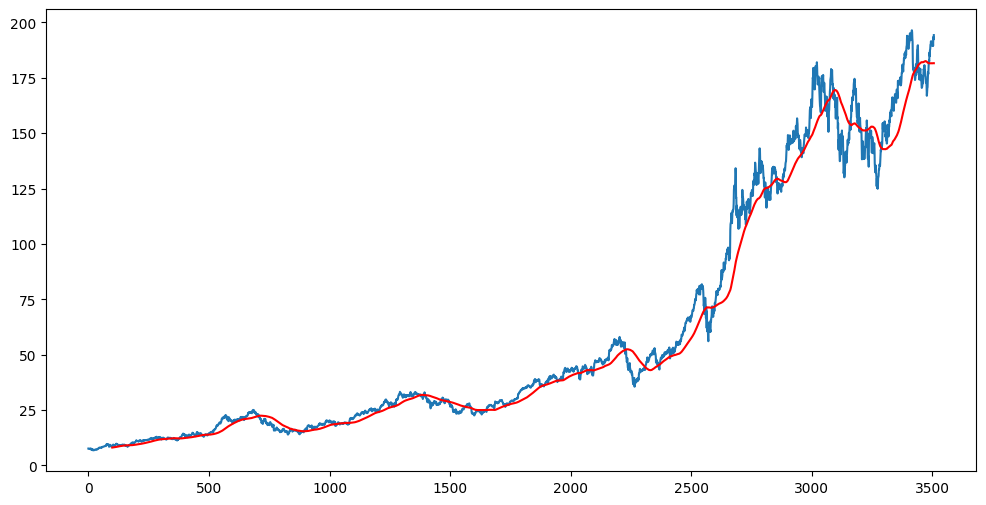

In [63]:
# Plotting 100 days moving average graph
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100,'red')

In [64]:
ma200 = df.Close.rolling(200).mean()
ma200

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6              NaN
7              NaN
8              NaN
9              NaN
10             NaN
11             NaN
12             NaN
13             NaN
14             NaN
15             NaN
16             NaN
17             NaN
18             NaN
19             NaN
20             NaN
21             NaN
22             NaN
23             NaN
24             NaN
25             NaN
26             NaN
27             NaN
28             NaN
29             NaN
30             NaN
31             NaN
32             NaN
33             NaN
34             NaN
35             NaN
36             NaN
37             NaN
38             NaN
39             NaN
40             NaN
41             NaN
42             NaN
43             NaN
44             NaN
45             NaN
46             NaN
47             NaN
48             NaN
49             NaN
50             NaN
51             NaN
52          

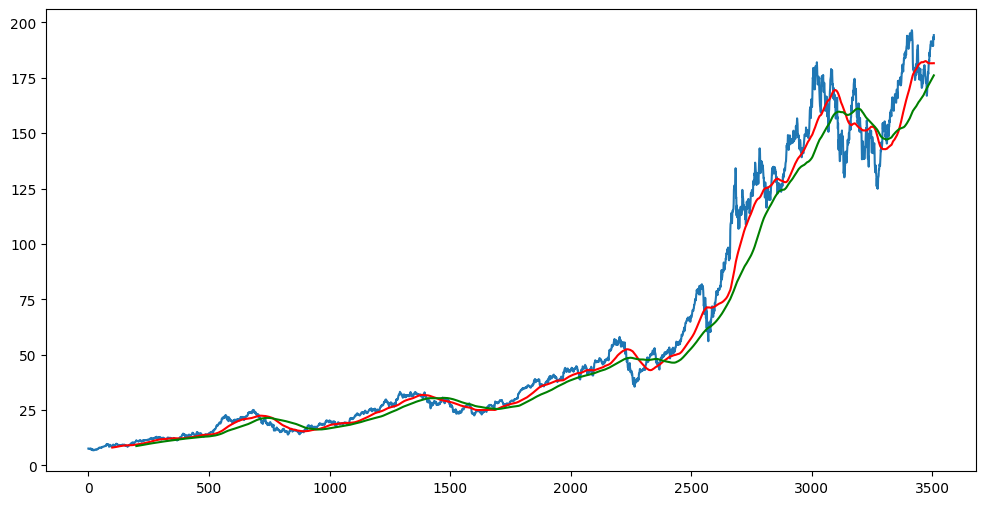

In [65]:
# Plotting 200 days moving average graph
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100,'r')
plt.plot(ma200,'g')

In [66]:
# Splitting data into training and testing
# We take 70% data for training and 30% for testing
data_training = pd.DataFrame(df['Close'][0:int(len(df)*0.7)])
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.7):int (len(df))])
print(data_training.shape)
print(data_testing.shape)

(2454, 1)
(1053, 1)


In [67]:
# Now we should move on to scaling down data for LSTM model
# We have to scale down it between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

In [68]:
# scaler.fit_transform return an array
data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[0.01533047],
       [0.01558878],
       [0.01320823],
       ...,
       [0.96041716],
       [0.96344693],
       [0.93593449]])

In [69]:
# Shape of data training array
data_training_array.shape

(2454, 1)

In [70]:
# First 100 days will be x_train
# And predicted value will be y_train
# In short x_train predicts y_train
x_train = []
y_train = []
for i in range(100,data_training_array.shape[0]):
  x_train.append(data_training_array[i-100:i])
  y_train.append(data_training_array[i,0])

In [71]:
# Converting x_train and y_train to numpy array
x_train, y_train = np.array(x_train),np.array(y_train)

In [72]:
x_train.shape
# Assume this as 2354 2D matrices each with 100 rows and 1 column

(2354, 100, 1)

In [73]:
y_train.shape

(2354,)

In [74]:
x_train

array([[[0.01533047],
        [0.01558878],
        [0.01320823],
        ...,
        [0.03819355],
        [0.03711847],
        [0.03634356]],

       [[0.01558878],
        [0.01320823],
        [0.01293595],
        ...,
        [0.03711847],
        [0.03634356],
        [0.04279409]],

       [[0.01320823],
        [0.01293595],
        [0.01391331],
        ...,
        [0.03634356],
        [0.04279409],
        [0.04525843]],

       ...,

       [[0.85745296],
        [0.84679984],
        [0.82950064],
        ...,
        [0.94605006],
        [0.94047915],
        [0.93525034]],

       [[0.84679984],
        [0.82950064],
        [0.77349834],
        ...,
        [0.94047915],
        [0.93525034],
        [0.96041716]],

       [[0.82950064],
        [0.77349834],
        [0.78786545],
        ...,
        [0.93525034],
        [0.96041716],
        [0.96344693]]])

In [75]:
y_train

array([0.04279409, 0.04525843, 0.04801596, ..., 0.96041716, 0.96344693,
       0.93593449])

# Creating ML Model using LSTM (Long Short Time Memory)

In [92]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
import keras as keras

In [77]:
model = Sequential()
# Adding Layers
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True,
               input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

# Connecting all layers
model.add(Dense(units = 1))

In [78]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_4 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_5 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_6 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_6 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_7 (LSTM)               (None, 120)              

In [277]:
model.compile(optimizer='adam', loss = 'mean_squared_error')
model.fit(x_train,y_train, epochs = 50)

Epoch 1/50
74/74 [==============================] - 13s 140ms/step - loss: 0.0371
Epoch 2/50
74/74 [==============================] - 10s 138ms/step - loss: 0.0079
Epoch 3/50
74/74 [==============================] - 10s 134ms/step - loss: 0.0064
Epoch 4/50
74/74 [==============================] - 10s 136ms/step - loss: 0.0061
Epoch 5/50
74/74 [==============================] - 10s 140ms/step - loss: 0.0054
Epoch 6/50
74/74 [==============================] - 11s 144ms/step - loss: 0.0056
Epoch 7/50
74/74 [==============================] - 10s 136ms/step - loss: 0.0056
Epoch 8/50
74/74 [==============================] - 10s 136ms/step - loss: 0.0047
Epoch 9/50
74/74 [==============================] - 10s 136ms/step - loss: 0.0045
Epoch 10/50
74/74 [==============================] - 10s 137ms/step - loss: 0.0040
Epoch 11/50
74/74 [==============================] - 10s 139ms/step - loss: 0.0046
Epoch 12/50
74/74 [==============================] - 10s 138ms/step - loss: 0.0038
Epoch 13/50
7

In [278]:
model.save('keras_model50.keras')

In [80]:
data_testing.tail(10)

,Close
3497,189.970001
3498,189.789993
3499,190.399994
3500,189.369995
3501,189.949997
3502,191.240005
3503,189.429993
3504,193.419998
3505,192.320007
3506,194.270004


In [81]:
past_100_days = data_training.tail(100)
past_100_days

,Close
2354,46.430000
2355,47.165001
2356,47.730000
2357,47.520000
2358,47.250000
2359,45.772499
2360,46.650002
2361,45.695000
2362,44.915001
2363,44.742500


In [82]:
final_df = pd.concat([past_100_days, data_testing], ignore_index=True)

In [83]:
final_df

,Close
0,46.430000
1,47.165001
2,47.730000
3,47.520000
4,47.250000
5,45.772499
6,46.650002
7,45.695000
8,44.915001
9,44.742500


In [84]:
final_df.tail(10)

,Close
1143,189.970001
1144,189.789993
1145,190.399994
1146,189.369995
1147,189.949997
1148,191.240005
1149,189.429993
1150,193.419998
1151,192.320007
1152,194.270004


In [85]:
# To scale down input data
input_data = scaler.fit_transform(final_df)
input_data

array([[0.02027755],
       [0.02507755],
       [0.02876734],
       ...,
       [0.98021225],
       [0.97302864],
       [0.98576331]])

In [86]:
input_data.shape

(1153, 1)

In [87]:
x_test = []
y_test = []
for i in range (100, input_data.shape[0]):
  x_test.append(input_data[i-100:i])
  y_test.append(input_data[i,0])

In [88]:
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)

(1053, 100, 1)


In [89]:
y_test

array([0.07758368, 0.08768978, 0.08777142, ..., 0.98021225, 0.97302864,
       0.98576331])

In [90]:
y_test.shape

(1053,)

In [101]:
# Making predictions
m1 = keras.models.load_model('keras_model.keras')
m2 = keras.models.load_model('keras_model50.keras')
y_predicted = m2.predict(x_test)

33/33 [==============================] - 2s 39ms/step


In [102]:
y_predicted.shape

(1053, 1)

In [103]:
y_predicted

array([[0.18205419],
       [0.18227074],
       [0.18250814],
       ...,
       [0.93504876],
       [0.9345879 ],
       [0.9353201 ]], dtype=float32)

In [104]:
y_predicted_original = scaler.inverse_transform(y_predicted.reshape(-1, 1))

y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))


In [105]:
y_predicted_original

array([[ 71.20205],
       [ 71.23521],
       [ 71.27156],
       ...,
       [186.50433],
       [186.43376],
       [186.54588]], dtype=float32)

In [106]:
y_test_original

array([[ 55.20500183],
       [ 56.75249863],
       [ 56.76499939],
       ...,
       [193.41999817],
       [192.32000732],
       [194.27000427]])

In [107]:
x_test

array([[[0.02027755],
        [0.02507755],
        [0.02876734],
        ...,
        [0.08272653],
        [0.08373877],
        [0.07454695]],

       [[0.02507755],
        [0.02876734],
        [0.02739592],
        ...,
        [0.08373877],
        [0.07454695],
        [0.07758368]],

       [[0.02876734],
        [0.02739592],
        [0.02563265],
        ...,
        [0.07454695],
        [0.07758368],
        [0.08768978]],

       ...,

       [[0.96238371],
        [0.98393475],
        [0.98223673],
        ...,
        [0.95755102],
        [0.96597557],
        [0.95415507]],

       [[0.98393475],
        [0.98223673],
        [0.99118373],
        ...,
        [0.96597557],
        [0.95415507],
        [0.98021225]],

       [[0.98223673],
        [0.99118373],
        [0.97831842],
        ...,
        [0.95415507],
        [0.98021225],
        [0.97302864]]])

In [108]:
y_test

array([0.07758368, 0.08768978, 0.08777142, ..., 0.98021225, 0.97302864,
       0.98576331])

In [109]:
y_predicted

array([[0.18205419],
       [0.18227074],
       [0.18250814],
       ...,
       [0.93504876],
       [0.9345879 ],
       [0.9353201 ]], dtype=float32)

In [119]:
# Concatenate x and y horizontally
result = np.concatenate((y_test_original, y_predicted_original), axis=1)

# Add headers for clarity
headers = ["Actual Prices", "Predicted Prices"]

# Use tabulate to print the result in a table format
table = tabulate(result, headers=headers, tablefmt="pretty", floatfmt=".5f")

# Print the formatted table
print(table)

+--------------------+--------------------+
|   Actual Prices    |  Predicted Prices  |
+--------------------+--------------------+
| 55.20500183105469  |  71.2020492553711  |
| 56.752498626708984 |  71.2352066040039  |
| 56.76499938964844  | 71.27156066894531  |
| 56.09999847412109  | 71.31727600097656  |
| 56.75749969482422  | 71.37232971191406  |
| 57.522499084472656 | 71.43759155273438  |
|  59.0525016784668  | 71.51641082763672  |
| 58.96749877929688  | 71.61820983886719  |
| 58.83000183105469  | 71.74797058105469  |
| 58.592498779296875 |  71.9046859741211  |
| 58.81999969482422  | 72.08201599121094  |
| 59.102500915527344 | 72.27256774902344  |
| 60.127498626708984 | 72.46975708007812  |
|  59.9900016784668  | 72.67249298095703  |
| 60.79499816894531  |  72.8785400390625  |
| 60.89500045776367  | 73.08876037597656  |
| 61.64500045776367  |  73.3030776977539  |
| 62.26250076293945  |  73.5234603881836  |
|  60.8224983215332  |  73.7530517578125  |
| 60.814998626708984 | 73.984207

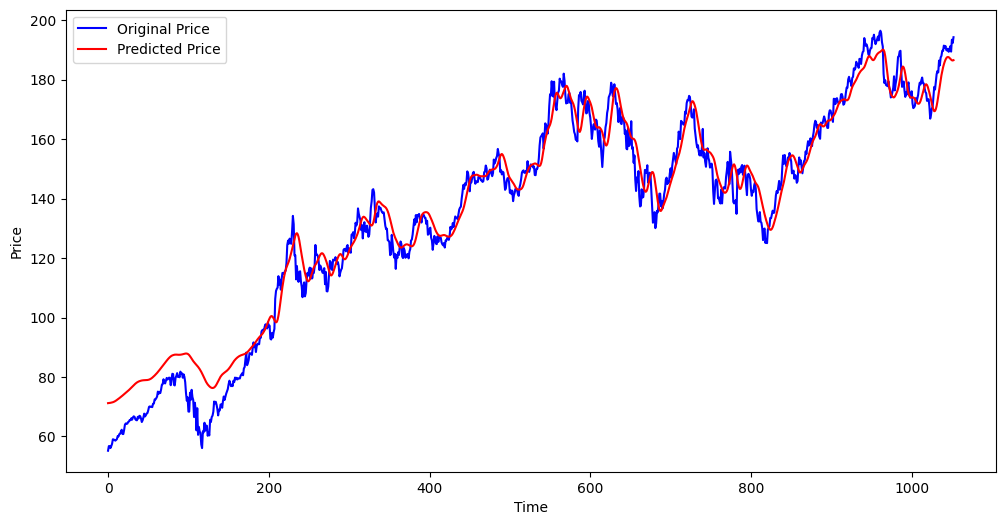

In [100]:
plt.figure(figsize = (12,6))
plt.plot(y_test_original ,'b',label='Original Price')
plt.plot(y_predicted_original, 'r', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [111]:
input_data = scaler.fit_transform(final_df)
import keras as keras
model = keras.models.load_model('keras_model.keras')

In [113]:
input_data = scaler.fit_transform(final_df)

# Get the last 100 days of data from the testing set
x_next_day = input_data[-100:]

# Reshape the data to match the input shape of the model
x_next_day = x_next_day.reshape(1, x_next_day.shape[0], 1)

# Use the trained model to predict the stock price for the next day
predicted_next_day_price = m2.predict(x_next_day)

# Invert the scaling to get the actual stock price
predicted_next_day_price = scaler.inverse_transform(predicted_next_day_price.reshape(-1, 1))

# Print the predicted stock price for the next day
print("Predicted Stock Price for the Next Day:", predicted_next_day_price[0, 0])

1/1 [==============================] - 0s 27ms/step
Predicted Stock Price for the Next Day: 186.86981
